In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
from torch.nn.parameter import Parameter

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mass = -0.2
lam = 0.5
def target_action(x):
    A = torch.sum(lam/24.0* x**4 + (mass+2.0)*(x**2)/2.0 - x*torch.roll(x,dims=1,shifts=-1),dim=1 )
    return A

In [3]:
x = torch.randn(1,2)

In [4]:
x.requires_grad

False

In [5]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
    
    # this is the forward start from noise target
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x
    
    # this is backward from target to noise
    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp #+ self.C
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x
    

In [6]:
# this are functions returning nets
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
# the number of masks determines layers
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [15]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):   
    #with torch.no_grad():
    z = prior.sample((2000, 1)).squeeze()
    x = flow.g(z) # generate a sample
    loss = (flow.log_prob(x)+target_action(x)).mean() # KL divergence (or not?)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step() 
    if t % 500 == 0:
        #print(z.shape)
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = -2.322
iter 500: loss = -2.324
iter 1000: loss = -2.326
iter 1500: loss = -2.323
iter 2000: loss = -2.326
iter 2500: loss = -2.321
iter 3000: loss = -2.324
iter 3500: loss = -2.321
iter 4000: loss = -2.326
iter 4500: loss = -2.324
iter 5000: loss = -2.323


In [16]:
z = prior.sample((10, 1)).squeeze()
x = flow.g(z)

In [17]:
zz,j=flow.f(x)

In [18]:
zz-z

tensor([[-2.3842e-07,  1.1921e-07],
        [ 1.1921e-07, -1.1921e-07],
        [ 2.3842e-07,  0.0000e+00],
        [-2.4214e-08, -5.9605e-08],
        [-8.9407e-08,  1.1921e-07],
        [-2.3842e-07,  1.1921e-07],
        [-8.9407e-08,  7.4506e-09],
        [ 0.0000e+00,  8.9407e-08],
        [-6.5565e-07, -4.7684e-07],
        [ 0.0000e+00, -4.1723e-07]], grad_fn=<SubBackward0>)

In [19]:
diff = target_action(x)+flow.log_prob(x)
print(diff)

tensor([-2.2894, -2.2944, -2.2748, -2.3628, -2.3553, -2.2675, -2.3106, -2.3004,
        -2.3906, -2.2086], grad_fn=<AddBackward0>)


In [20]:
print(diff - diff.mean())

tensor([ 0.0160,  0.0111,  0.0306, -0.0574, -0.0498,  0.0379, -0.0052,  0.0051,
        -0.0852,  0.0968], grad_fn=<SubBackward0>)


In [21]:
((diff)**2).mean()

tensor(5.3176, grad_fn=<MeanBackward0>)

In [22]:
print(zz.requires_grad,z.requires_grad)

True False


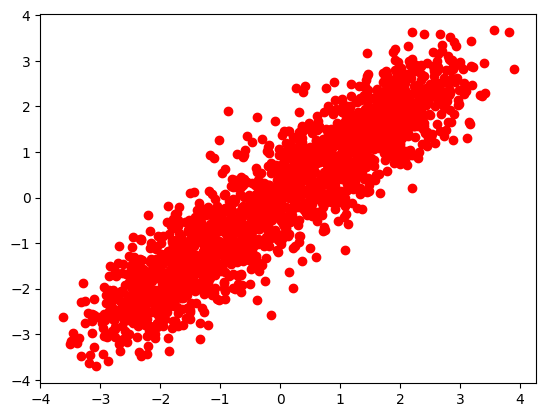

In [27]:
x = flow.sample(2000).detach().numpy()
plt.scatter(x[:, 0,0], x[:, 0,1], c='r')